In [2]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [3]:
from statsmodels.tsa.arima.model import ARIMA
from Modelling import modelling
import matplotlib.pyplot as plt
from DataPrep.ImportData import importer
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pyforest
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = importer().Import()

In [5]:
def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [6]:
models = pd.read_csv("ArmaModels.csv")

<IPython.core.display.Javascript object>

,Unnamed: 0,Label,ar,ma,AIC,r^2,RMSE,MAPE,MAE,SMAPE
0,0,0.0,0.0,0.0,2419.405539,-0.149268,0.483292,0.170329,0.377243,8.092327
1,1,0.0,0.0,1.0,2072.314689,-0.833469,0.610430,0.214274,0.481501,10.265525
2,2,0.0,0.0,2.0,2082.260000,-0.591167,0.568665,0.201987,0.444264,9.492421
3,3,0.0,0.0,3.0,2096.356094,-0.510657,0.554092,0.195507,0.432867,9.259002
4,4,0.0,0.0,4.0,2099.985796,-0.354790,0.524729,0.185126,0.406255,8.694197
...,...,...,...,...,...,...,...,...,...,...
795,795,7.0,9.0,5.0,2101.598256,-0.333243,0.699749,0.270990,0.530215,9.824939
796,796,7.0,9.0,6.0,2114.978766,-0.261892,0.680767,0.273626,0.519472,9.593291
797,797,7.0,9.0,7.0,2113.698785,-0.260641,0.680430,0.269603,0.514853,9.523004
798,798,7.0,9.0,8.0,2113.522585,-0.249292,0.677360,0.271322,0.517590,9.554762


In [15]:
for i in range(8):
    print(models[(models["Label"]==i) & (models["AIC"]==models[models["Label"]==i]["AIC"].min())])

    Unnamed: 0  Label   ar   ma  ...      RMSE      MAPE       MAE      SMAPE
11          11    0.0  1.0  1.0  ...  0.914322  0.316311  0.718366  15.746497

[1 rows x 10 columns]
     Unnamed: 0  Label   ar   ma  ...      RMSE      MAPE       MAE     SMAPE
162         162    1.0  6.0  2.0  ...  0.664614  0.184643  0.508963  8.840542

[1 rows x 10 columns]
     Unnamed: 0  Label   ar   ma  ...      RMSE      MAPE       MAE     SMAPE
201         201    2.0  0.0  1.0  ...  0.498334  0.142621  0.375522  7.104982

[1 rows x 10 columns]
     Unnamed: 0  Label   ar   ma  ...     RMSE     MAPE       MAE      SMAPE
338         338    3.0  3.0  8.0  ...  1.30905  0.23808  1.010138  11.518339

[1 rows x 10 columns]
     Unnamed: 0  Label   ar   ma  ...     RMSE          MAPE       MAE      SMAPE
495         495    4.0  9.0  5.0  ...  1.03749  8.003120e+13  0.831469  19.095269

[1 rows x 10 columns]
     Unnamed: 0  Label   ar   ma  ...     RMSE      MAPE       MAE      SMAPE
511         511    5.

Label: 6.0


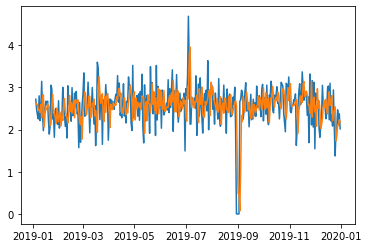

r^2: -0.18535620858587087


<IPython.core.display.Javascript object>

RMSE 0.5398398835534193
MAPE 59333656154284.484
MAE 0.4045252623557605


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Smape: 8.926499414168024


In [18]:
def ArmaModels(df,label,ar,ma):
    print(f"Label: {label}")
    df=df[df["Label"]==label]
    df=df.sort_values("Start Date")
    y = df[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False) 


    y= y.resample("d").min()
    X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    X_train=X_train.drop(columns="lag_0")
    X_test=X_test.drop(columns="lag_0")
    y_train = y_train.set_index("Start Date",drop=False)
    y_test = y_test.set_index("Start Date",drop=False)

    y_train.freq= "D"
    y_train = y_train.resample("d").min()
    y_test = y_test.resample("d").min()
    y_train["Energy (kWh)"]  = y_train["Energy (kWh)"].fillna(0)
    y_test["Energy (kWh)"]  = y_test["Energy (kWh)"].fillna(0)

    

    sam = ARIMA((y_train["Energy (kWh)"]),exog=X_train.fillna(0), order=(ar,0,ma), trend="n", freq="D")
    sam_fit = sam.fit()
    #print(sam_fit.summary())

    n=len(y_test["Energy (kWh)"])
    y_pred = sam_fit.forecast(steps = n, exog=X_test.fillna(0))
    plt.plot(y_test["Energy (kWh)"])
    plt.plot(y_pred)
    plt.show()


    print("r^2:", r2_score(y_test["Energy (kWh)"],y_pred))
    print("RMSE",np.sqrt(mean_squared_error(y_test["Energy (kWh)"],y_pred))) 
    print("MAPE",mean_absolute_percentage_error(y_test["Energy (kWh)"],y_pred))
    print("MAE",mean_absolute_error(y_test["Energy (kWh)"],y_pred))
    print("Smape:", smape(y_test['Energy (kWh)'],y_pred))
ArmaModels(df,6.0,8,6)